In [10]:
# install DGL in Colab
!pip install dgl -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://data.dgl.ai/wheels/repo.html


In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import dgl

In [12]:
!wget http://snap.stanford.edu/data/facebook.tar.gz
!tar -xvf "facebook.tar.gz"

'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'facebook.tar.gz'


In [13]:
# user id, which correspond to file name prefix
USER = 0

file_edges = f'facebook/{USER}.edges'
file_feat = f'facebook/{USER}.feat'

edges_u, edges_v = [], []

with open(file_edges) as f:
    for line in f:
        e1, e2 = tuple(int(x) - 1 for x in line.split())
        edges_u.append(e1)
        edges_v.append(e2)

edges_u, edges_v = np.array(edges_u), np.array(edges_v)

num_nodes = 0
feats = []  

with open(file_feat) as f:  
    for line in f:
        num_nodes += 1
        a = [int(x) for x in line.split()[1:]] 
        feats.append(torch.tensor(a, dtype=torch.float))

feats = torch.stack(feats)

g = dgl.graph((edges_u, edges_v))  # construct graph
g.ndata['feat'] = feats

g  # print graph metadata

Graph(num_nodes=347, num_edges=5038,
      ndata_schemes={'feat': Scheme(shape=(224,), dtype=torch.float32)}
      edata_schemes={})

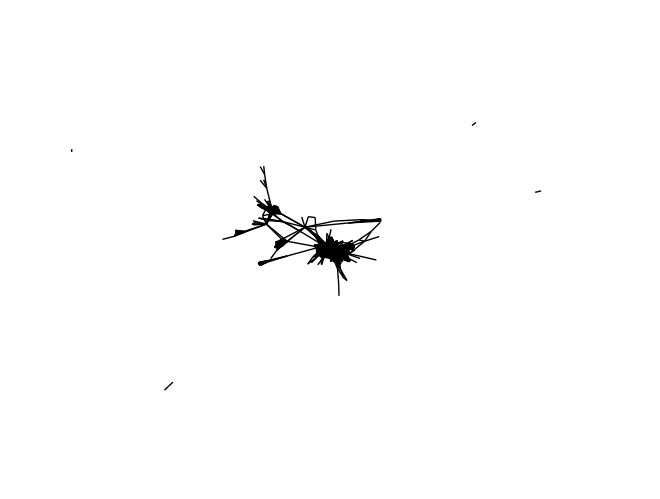

In [14]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(set(edges_u + edges_v))
G.add_edges_from(zip(edges_u, edges_v))

nx.draw(G, node_size=0)

In [15]:
TEST_RATIO = 0.3  

u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * TEST_RATIO) 
train_size = g.number_of_edges() - test_size  

test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]


train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

train_g = dgl.remove_edges(g, eids[:test_size])
train_g = dgl.add_self_loop(train_g)

In [16]:
from dgl.nn.pytorch import SAGEConv
from dgl.nn.pytorch import GraphConv


class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)  
        self.conv2 = GraphConv(h_feats, h_feats)   
        self.conv3 = GraphConv(h_feats, out_feats) 

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv3(g, h)
        return h

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]


In [17]:


def pipeline(model_name='GCN', hidden_size=16, out_size=16):
    if model_name == 'GCN':
        model = GCN(train_g.ndata['feat'].shape[1], hidden_size, out_size)
    elif model_name == 'SAGE':
        model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_size)

    pred = DotPredictor()

    def compute_loss(pos_score, neg_score):
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
        return F.binary_cross_entropy_with_logits(scores, labels)

    def compute_auc(pos_score, neg_score):
        scores = torch.cat([pos_score, neg_score]).numpy()
        labels = torch.cat(
            [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
        return roc_auc_score(labels, scores)

    # ----------- loss và optimizer -------------- #
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)


    all_logits = []
    for e in range(100):
        # forward
        h = model(train_g, train_g.ndata['feat'])  # lấy embeddings của các nút
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('Epoch {}, loss: {}'.format(e, loss))

    # ----------- kiểm tra kết quả ---------------- #
    from sklearn.metrics import roc_auc_score
    with torch.no_grad():
        pos_score = pred(test_pos_g, h)
        neg_score = pred(test_neg_g, h)
        print('AUC', compute_auc(pos_score, neg_score))

    return h  # trả về node embeddings



### Training and testing GCN:

In [18]:
h = pipeline("GCN")

C:\Users\Lenovo\Desktop\ck\project\Lib\site-packages\dgl\backend\pytorch\tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0, loss: 0.6825820803642273
Epoch 5, loss: 0.601263701915741
Epoch 10, loss: 0.5194957256317139
Epoch 15, loss: 0.4987867772579193
Epoch 20, loss: 0.47313207387924194
Epoch 25, loss: 0.4683798551559448
Epoch 30, loss: 0.46426862478256226
Epoch 35, loss: 0.45829877257347107
Epoch 40, loss: 0.4549350142478943
Epoch 45, loss: 0.4527356028556824
Epoch 50, loss: 0.45009252429008484
Epoch 55, loss: 0.44828033447265625
Epoch 60, loss: 0.4459567666053772
Epoch 65, loss: 0.44351840019226074
Epoch 70, loss: 0.4410499334335327
Epoch 75, loss: 0.4384424686431885
Epoch 80, loss: 0.43548762798309326
Epoch 85, loss: 0.4317610263824463
Epoch 90, loss: 0.4274199903011322
Epoch 95, loss: 0.4253356456756592
AUC 0.9352776309271387


### Training and testing SAGE:

In [19]:
h = pipeline("SAGE")

Epoch 0, loss: 1.8350573778152466
Epoch 5, loss: 0.6589620113372803
Epoch 10, loss: 0.6283072829246521
Epoch 15, loss: 0.5901339054107666
Epoch 20, loss: 0.552445650100708
Epoch 25, loss: 0.5198664665222168
Epoch 30, loss: 0.4977782368659973
Epoch 35, loss: 0.4859451353549957
Epoch 40, loss: 0.4770163893699646
Epoch 45, loss: 0.4689989984035492
Epoch 50, loss: 0.4618234634399414
Epoch 55, loss: 0.4554063081741333
Epoch 60, loss: 0.4492294192314148
Epoch 65, loss: 0.44328582286834717
Epoch 70, loss: 0.43797340989112854
Epoch 75, loss: 0.4329952597618103
Epoch 80, loss: 0.4281344711780548
Epoch 85, loss: 0.4234820604324341
Epoch 90, loss: 0.41892993450164795
Epoch 95, loss: 0.4144465923309326
AUC 0.9090170866984272


In [20]:
# --------- generate recommendation for user -------- #
def generate_rec(h, user_id=0):
    # `h` represents the node embeddings, with shape [num_nodes, hidden_size]

    # generate a graph with (num_nodes - num_friends_of_user) edges
    # one end of the edge is user_id
    # the other end is a user that's NOT friends with user_id
    user_friends = set()
    user_neg_u, user_neg_v = [], []
    for n1, n2 in zip(u, v):   # get all friends of user_id
        if int(n1) == user_id:
            user_friends.add(int(n2))
        if int(n2) == user_id:
            user_friends.add(int(n1))

    for i in range(num_nodes):  # generate "negative edges" for user_id
        if i != user_id and i not in user_friends:
            user_neg_u.append(user_id)
            user_neg_v.append(i)

    user_g = dgl.graph((user_neg_u, user_neg_v), num_nodes=g.number_of_nodes())

    pred = DotPredictor()

    # calculate the score of each user
    scores = [(i, score) for i, score in enumerate(pred(user_g, h))]

    # produce final ranked list
    scores.sort(key=lambda x: -x[1])

    # display results
    print(f"List of 5 suggested friends for user {user_id}:")
    for i in range(5):
        print(f'- User {scores[i][0]}, score = {scores[i][1]}')


In [21]:
generate_rec(h, user_id=4)

List of 5 suggested friends for user 4:
- User 78, score = 2.5115408897399902
- User 288, score = 2.4016377925872803
- User 254, score = 2.22143292427063
- User 91, score = 2.1540632247924805
- User 306, score = 2.1484627723693848
